In [32]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob
from pathlib import Path
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

class readerFile:

    def __init__(self, file_path):
        self.file_path = file_path
        header, data = self.__read_file()

        hdu = fits.PrimaryHDU(data)
        self.__get_header_format(header, hdu)

        hdul = fits.HDUList([hdu])
        # self.header = header
        self.hdul = hdul

    def read(self):
        return self.hdul
        

    def __read_file(self):
        header = []
        
        with open(self.file_path, 'r') as file:
            lines = file.readlines()
            
            # Skip the first empty line
            lines = lines[1:]  # Skip first empty line
            
            # Now separate the header and content
            header_found = False
            for i, line in enumerate(lines):
                if header_found:
                    break
                elif line.strip() == '':  # Empty line indicates end of header
                    header_found = True
                else:
                    header.append(line.strip())
    
        data = np.genfromtxt(self.file_path, unpack=True, skip_header=107)
        return header, data

    def __parse_value(self, value):
        """Parse the string value to the appropriate type (float, int, or str)."""
        value_stripped = value.strip()  # Remove any leading/trailing whitespace
        # Try converting to an int first
        if value_stripped.isdigit():  # Check if it's a positive integer
            return int(value_stripped)
        # Try converting to a float next
        try:
            return float(value_stripped)
        except ValueError:
            return value_stripped  # Return as string if not float or int


    def __get_header_format(self, header, hdu):

        for line in header:
            param_name, param_val = line.split(':')
            parsed_value = self.__parse_value(param_val)

            hdu.header[param_name] = parsed_value

        return

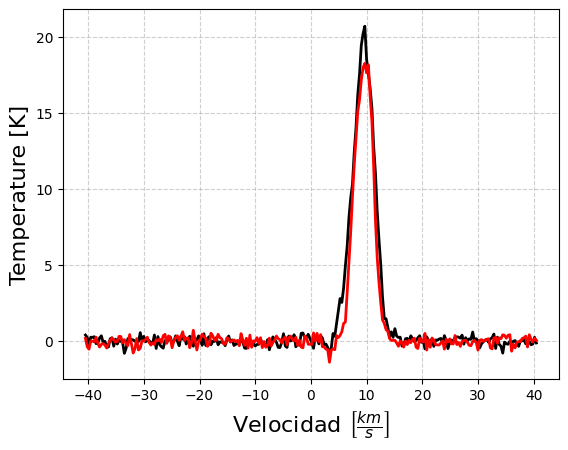

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                    2                                                  
EXTEND  =                    T                                                  
FMT     =                   15                                                  
SOURCENM= 'Orion   '                                                            
COMNT   = ''                                                                    
OBSNAME = 'AE      '                                                            
ISCAN   =                125.0                                                  
QUALITY =                    0                                                  
YEAR    =                 20

In [33]:
spec_data = []
for i in range(5):
    mypath = "C:/Users/nicol/Documents/Astro_Exp/Radio 1" \
    "/datos_espectros/Pos " + str(i + 1) + "/sdf*"
    spec_path = sorted(glob.glob(mypath))
    spec_pos = []
    for j in spec_path:
        spec_j = readerFile(j).read()
        spec_pos += spec_j
    for j, i in enumerate(spec_pos):
        hdr = i.header
        v, T = i.data
        lii, bii = hdr['LII'], hdr['BII']
        data = (lii, bii, v, T)
        spec_pos[j] = data
    spec_data.append(spec_pos)

# spec_data[2][0][:2]
# 

plt.plot(spec_data[0][0][2], spec_data[0][0][3], color="black", linestyle="-", linewidth=2)
plt.plot(spec_data[1][0][2], spec_data[1][0][3], color="red", linestyle="-", linewidth=2)
plt.xlabel(r"Velocidad $\left[ \frac{km}{s}\right]$", fontsize=16)
plt.ylabel(r"Temperature [K]", fontsize=16)

plt.grid(True, linestyle="--", alpha=0.6)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

hdr

In [34]:
spec_vT_means = []
for i in spec_data:
    spec_T = np.array([el[3] for el in i])
    spec_v = np.array([el[2] for el in i])

    l = len(spec_T)
    
    sums_T = np.cumsum(np.stack(spec_T), axis = 0)
    sums_v = np.cumsum(np.stack(spec_v), axis = 0)
    div = np.linspace(1, l, l).reshape(-1, 1)

    means_T = sums_T/div
    means_v = sums_v/div

    vT_pos = []
    for j, k in zip(means_v, means_T):
        vT = (j, k)
        vT_pos.append(vT)
    spec_vT_means.append(vT_pos)


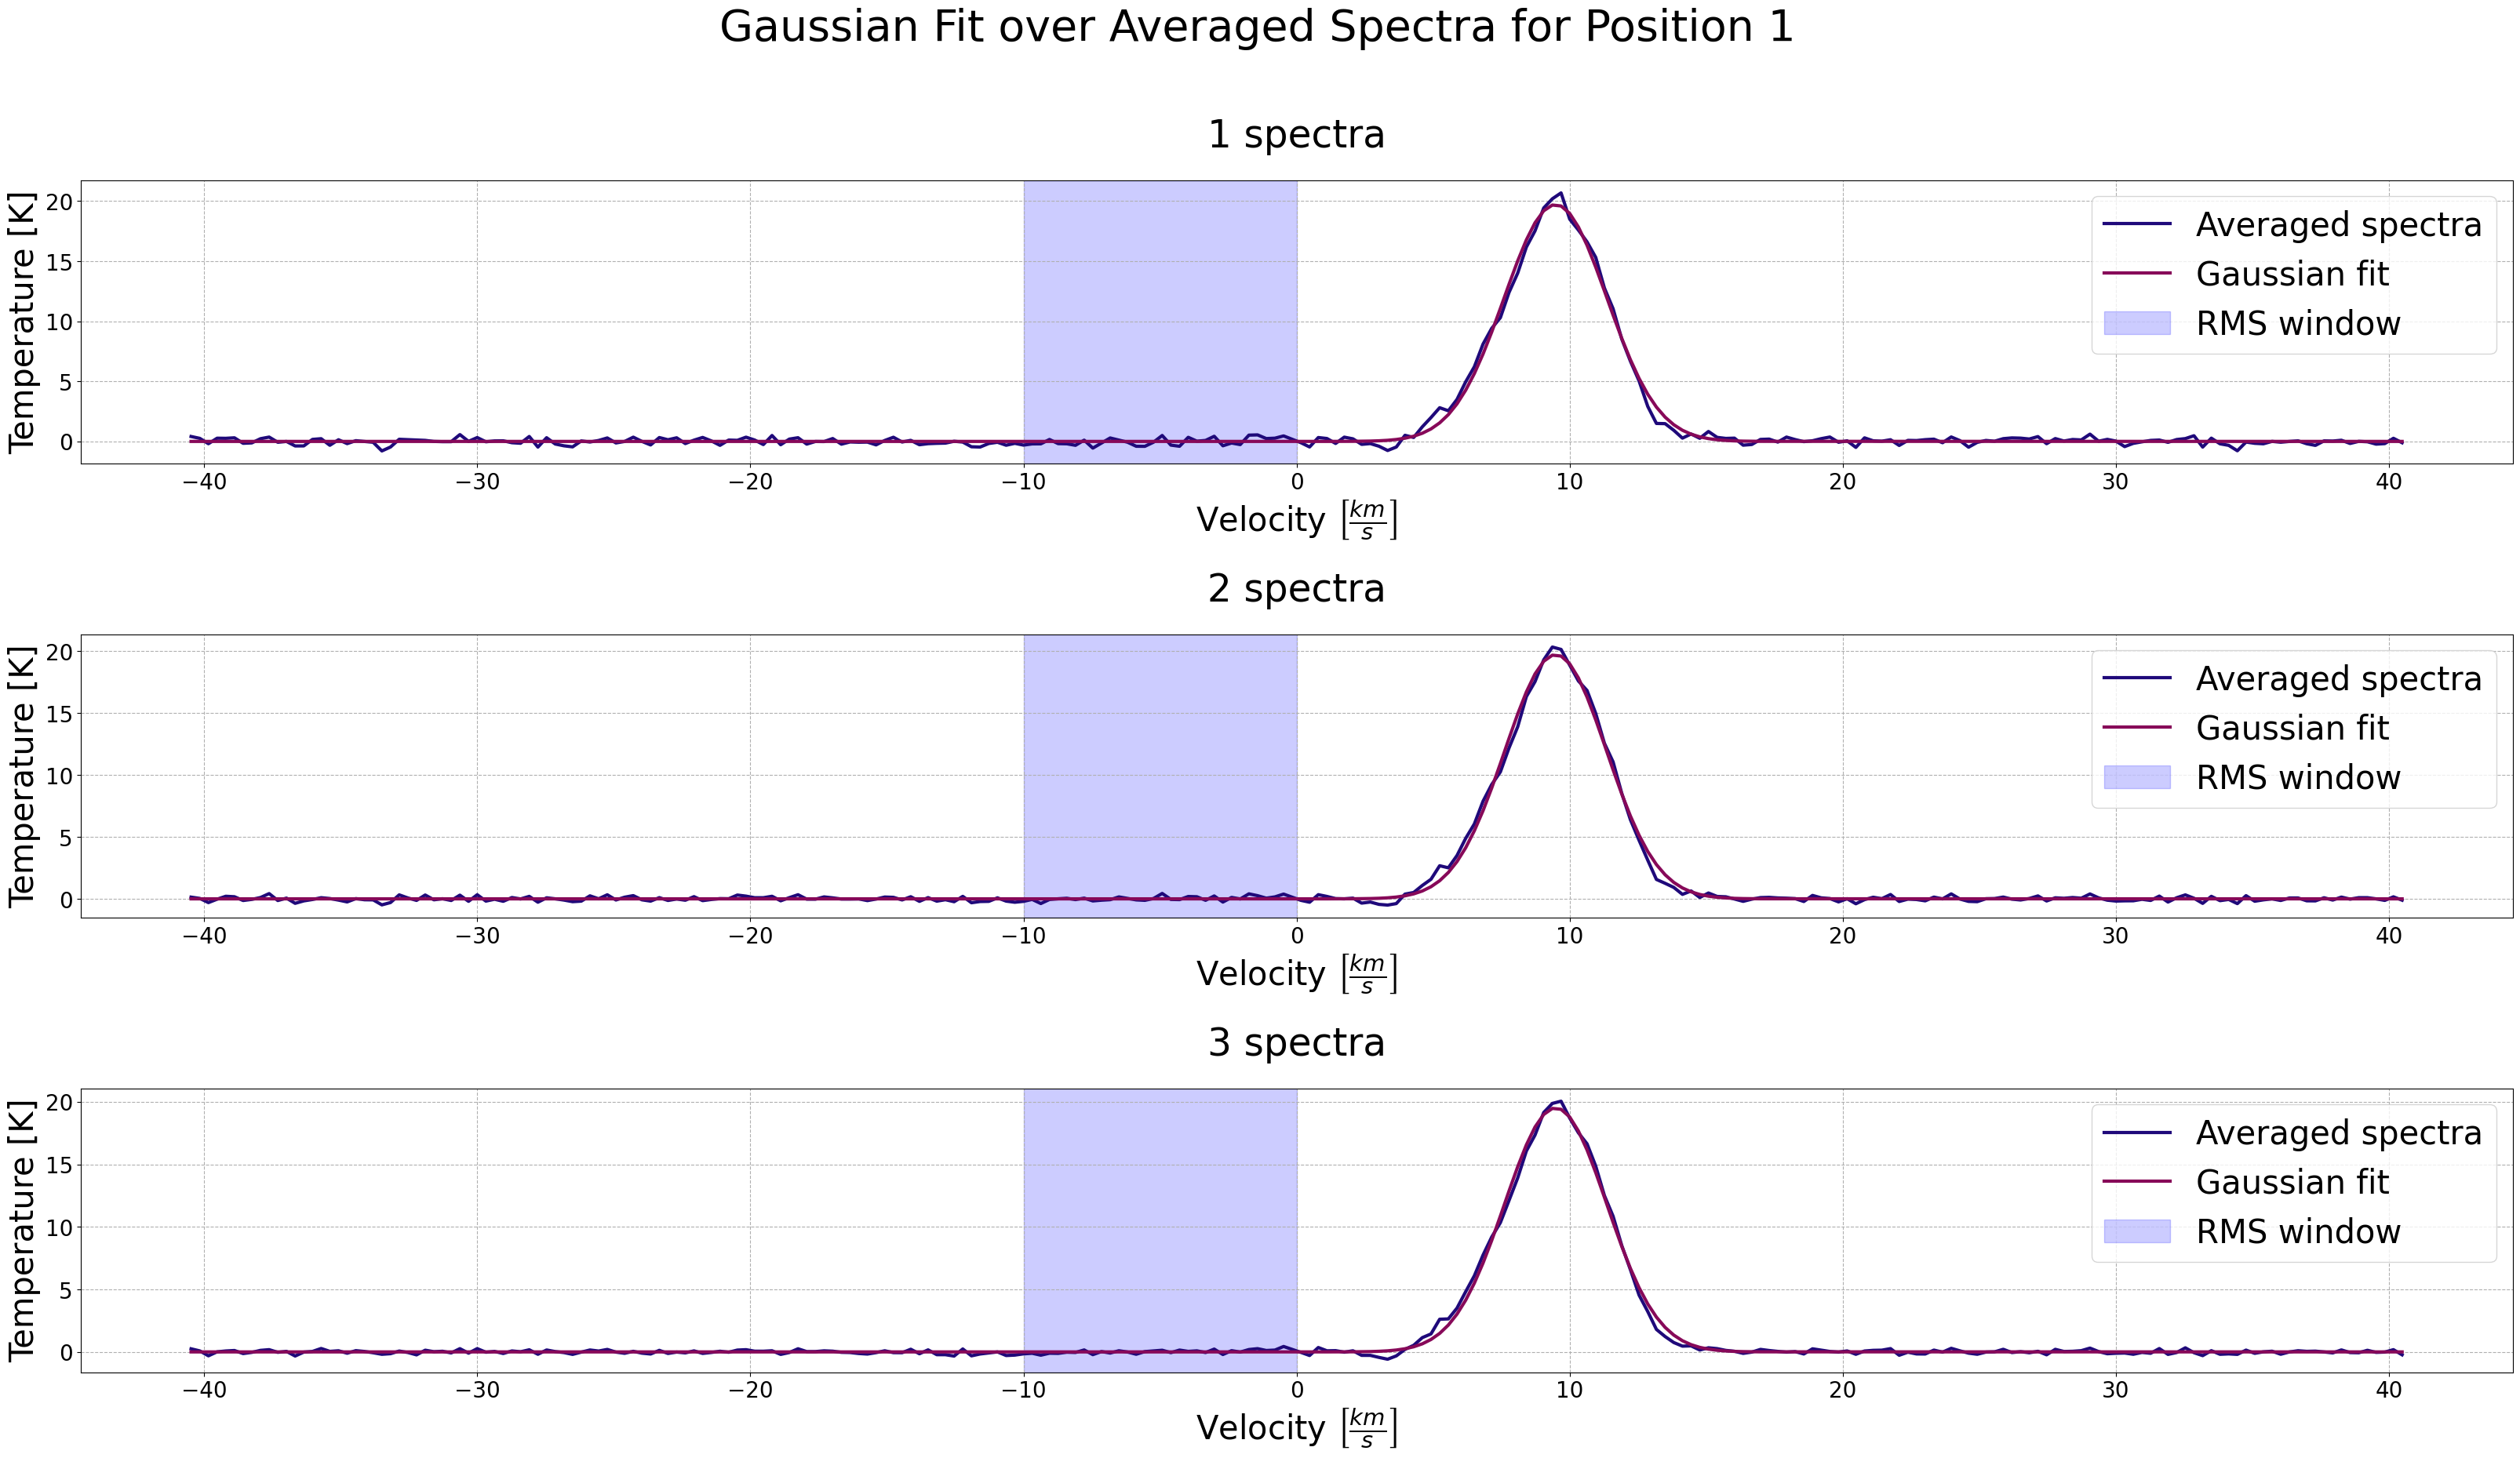

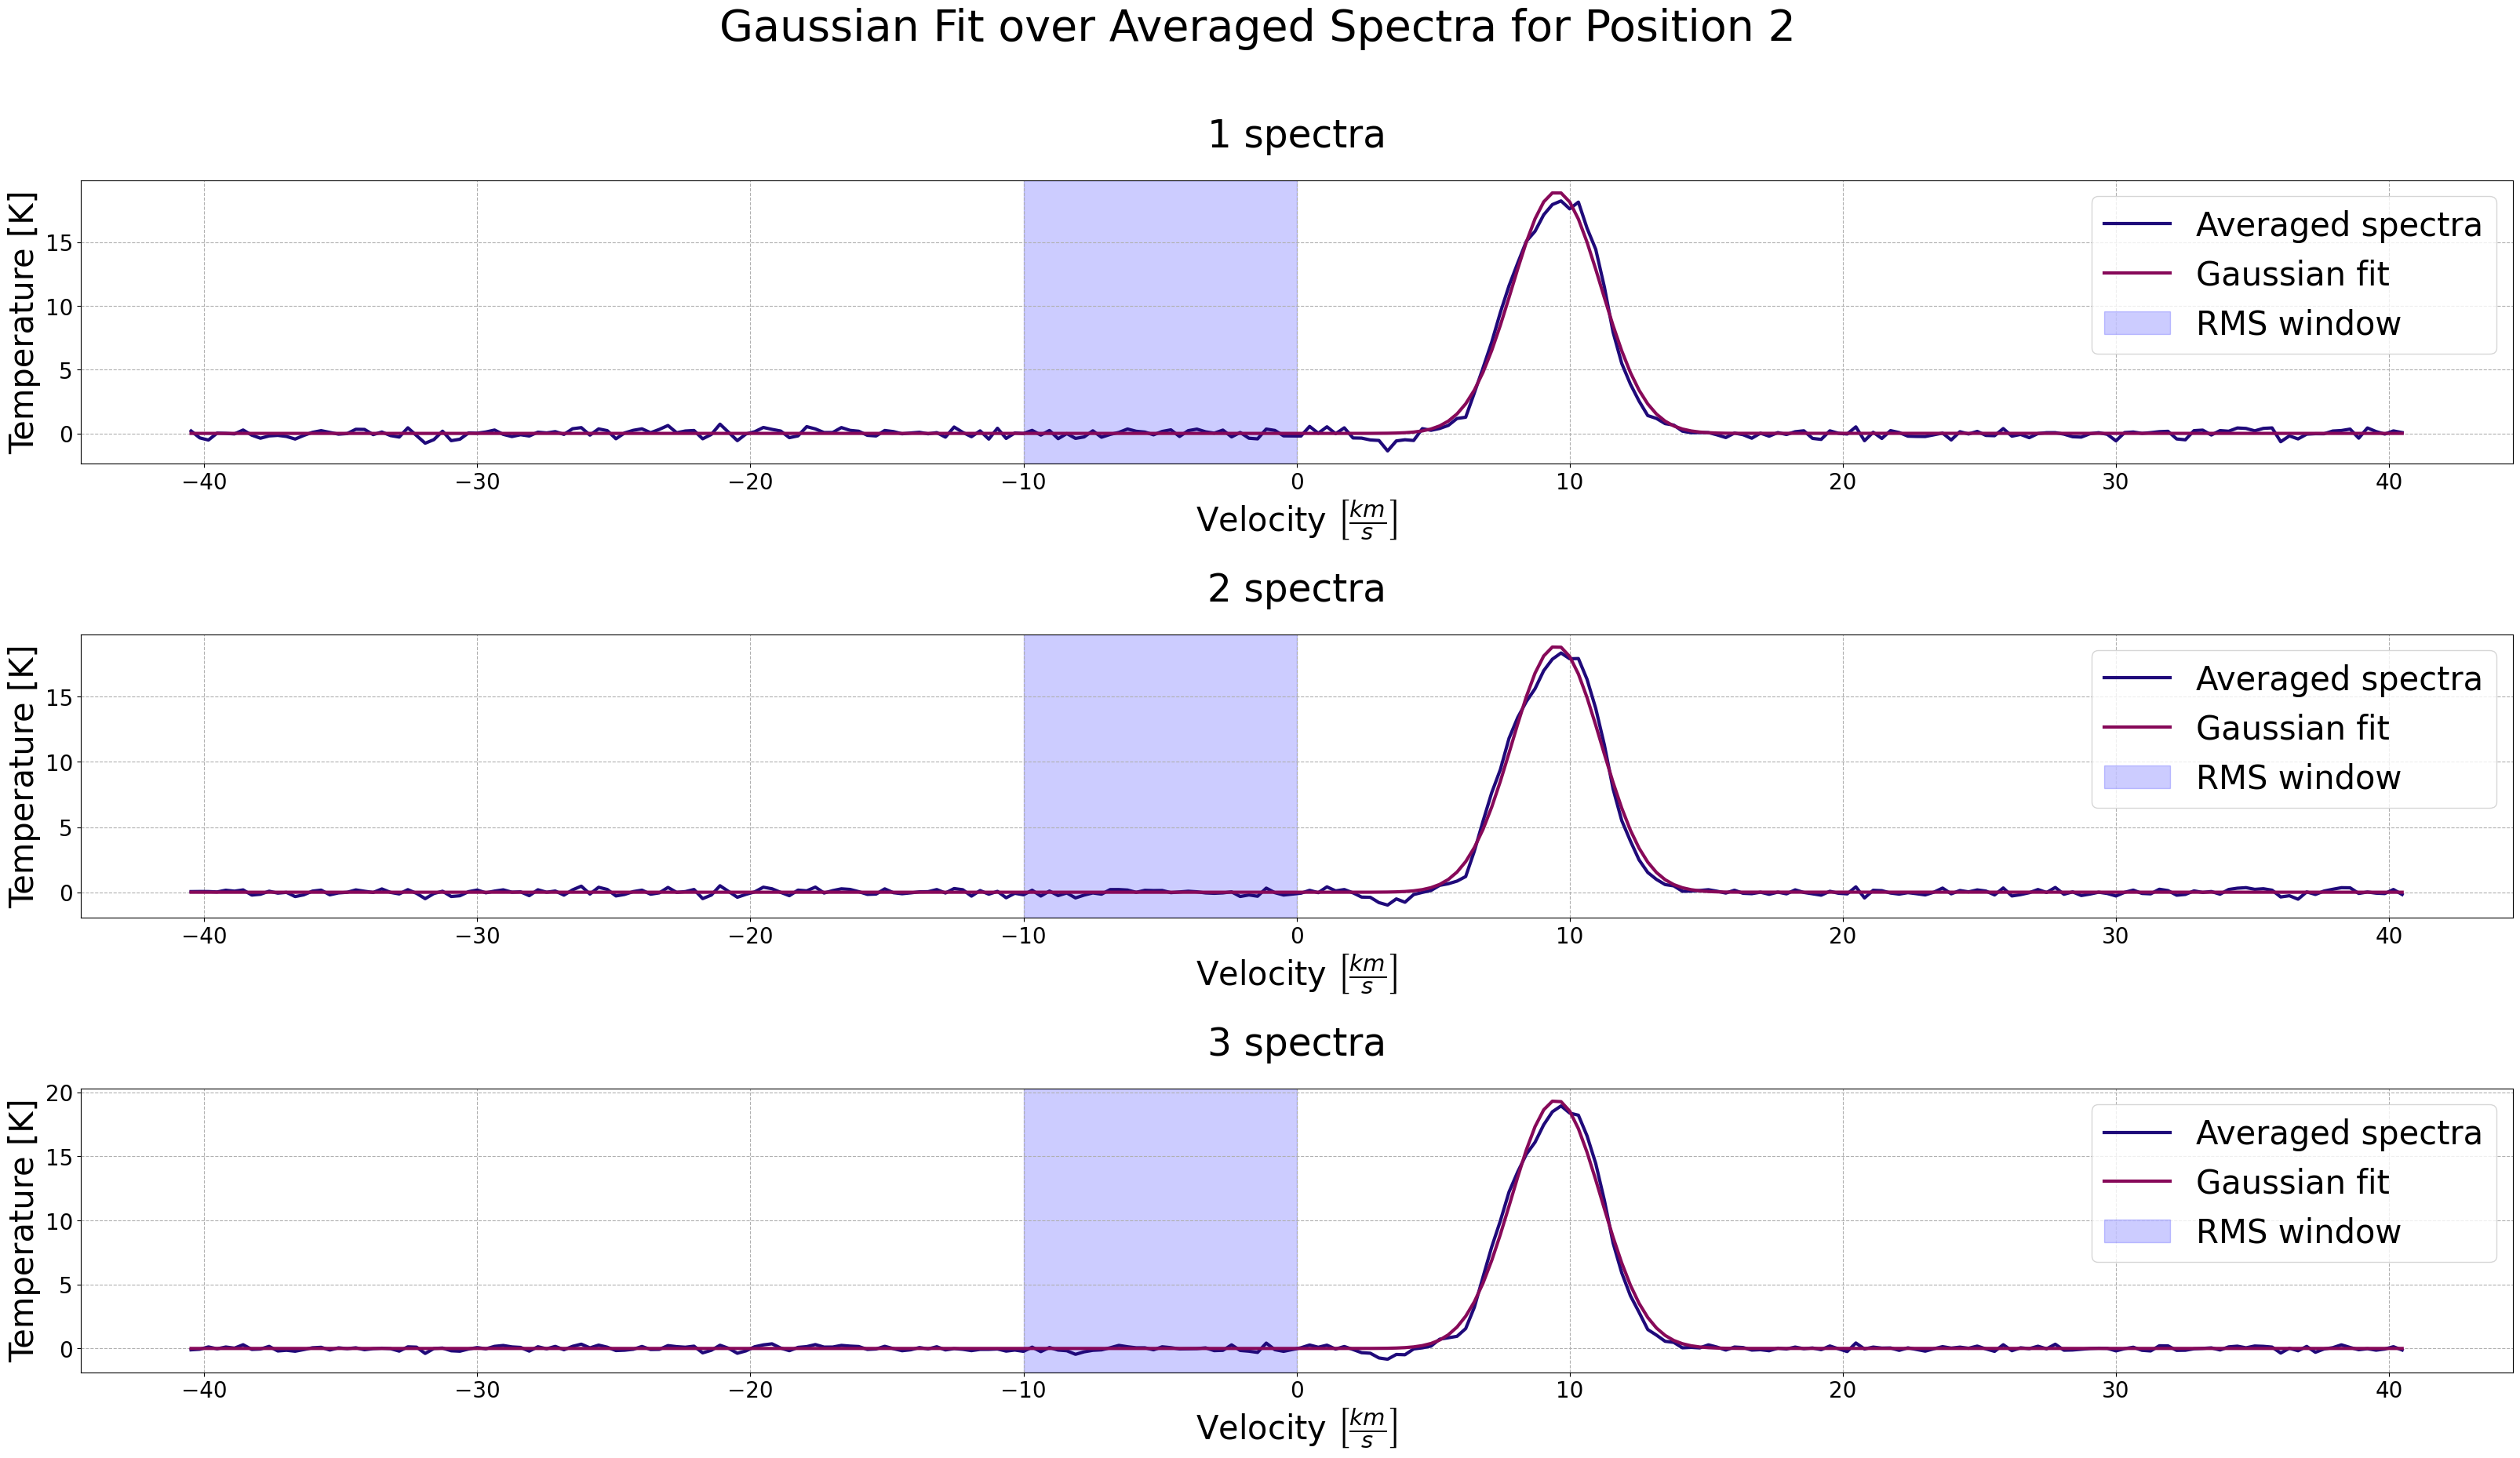

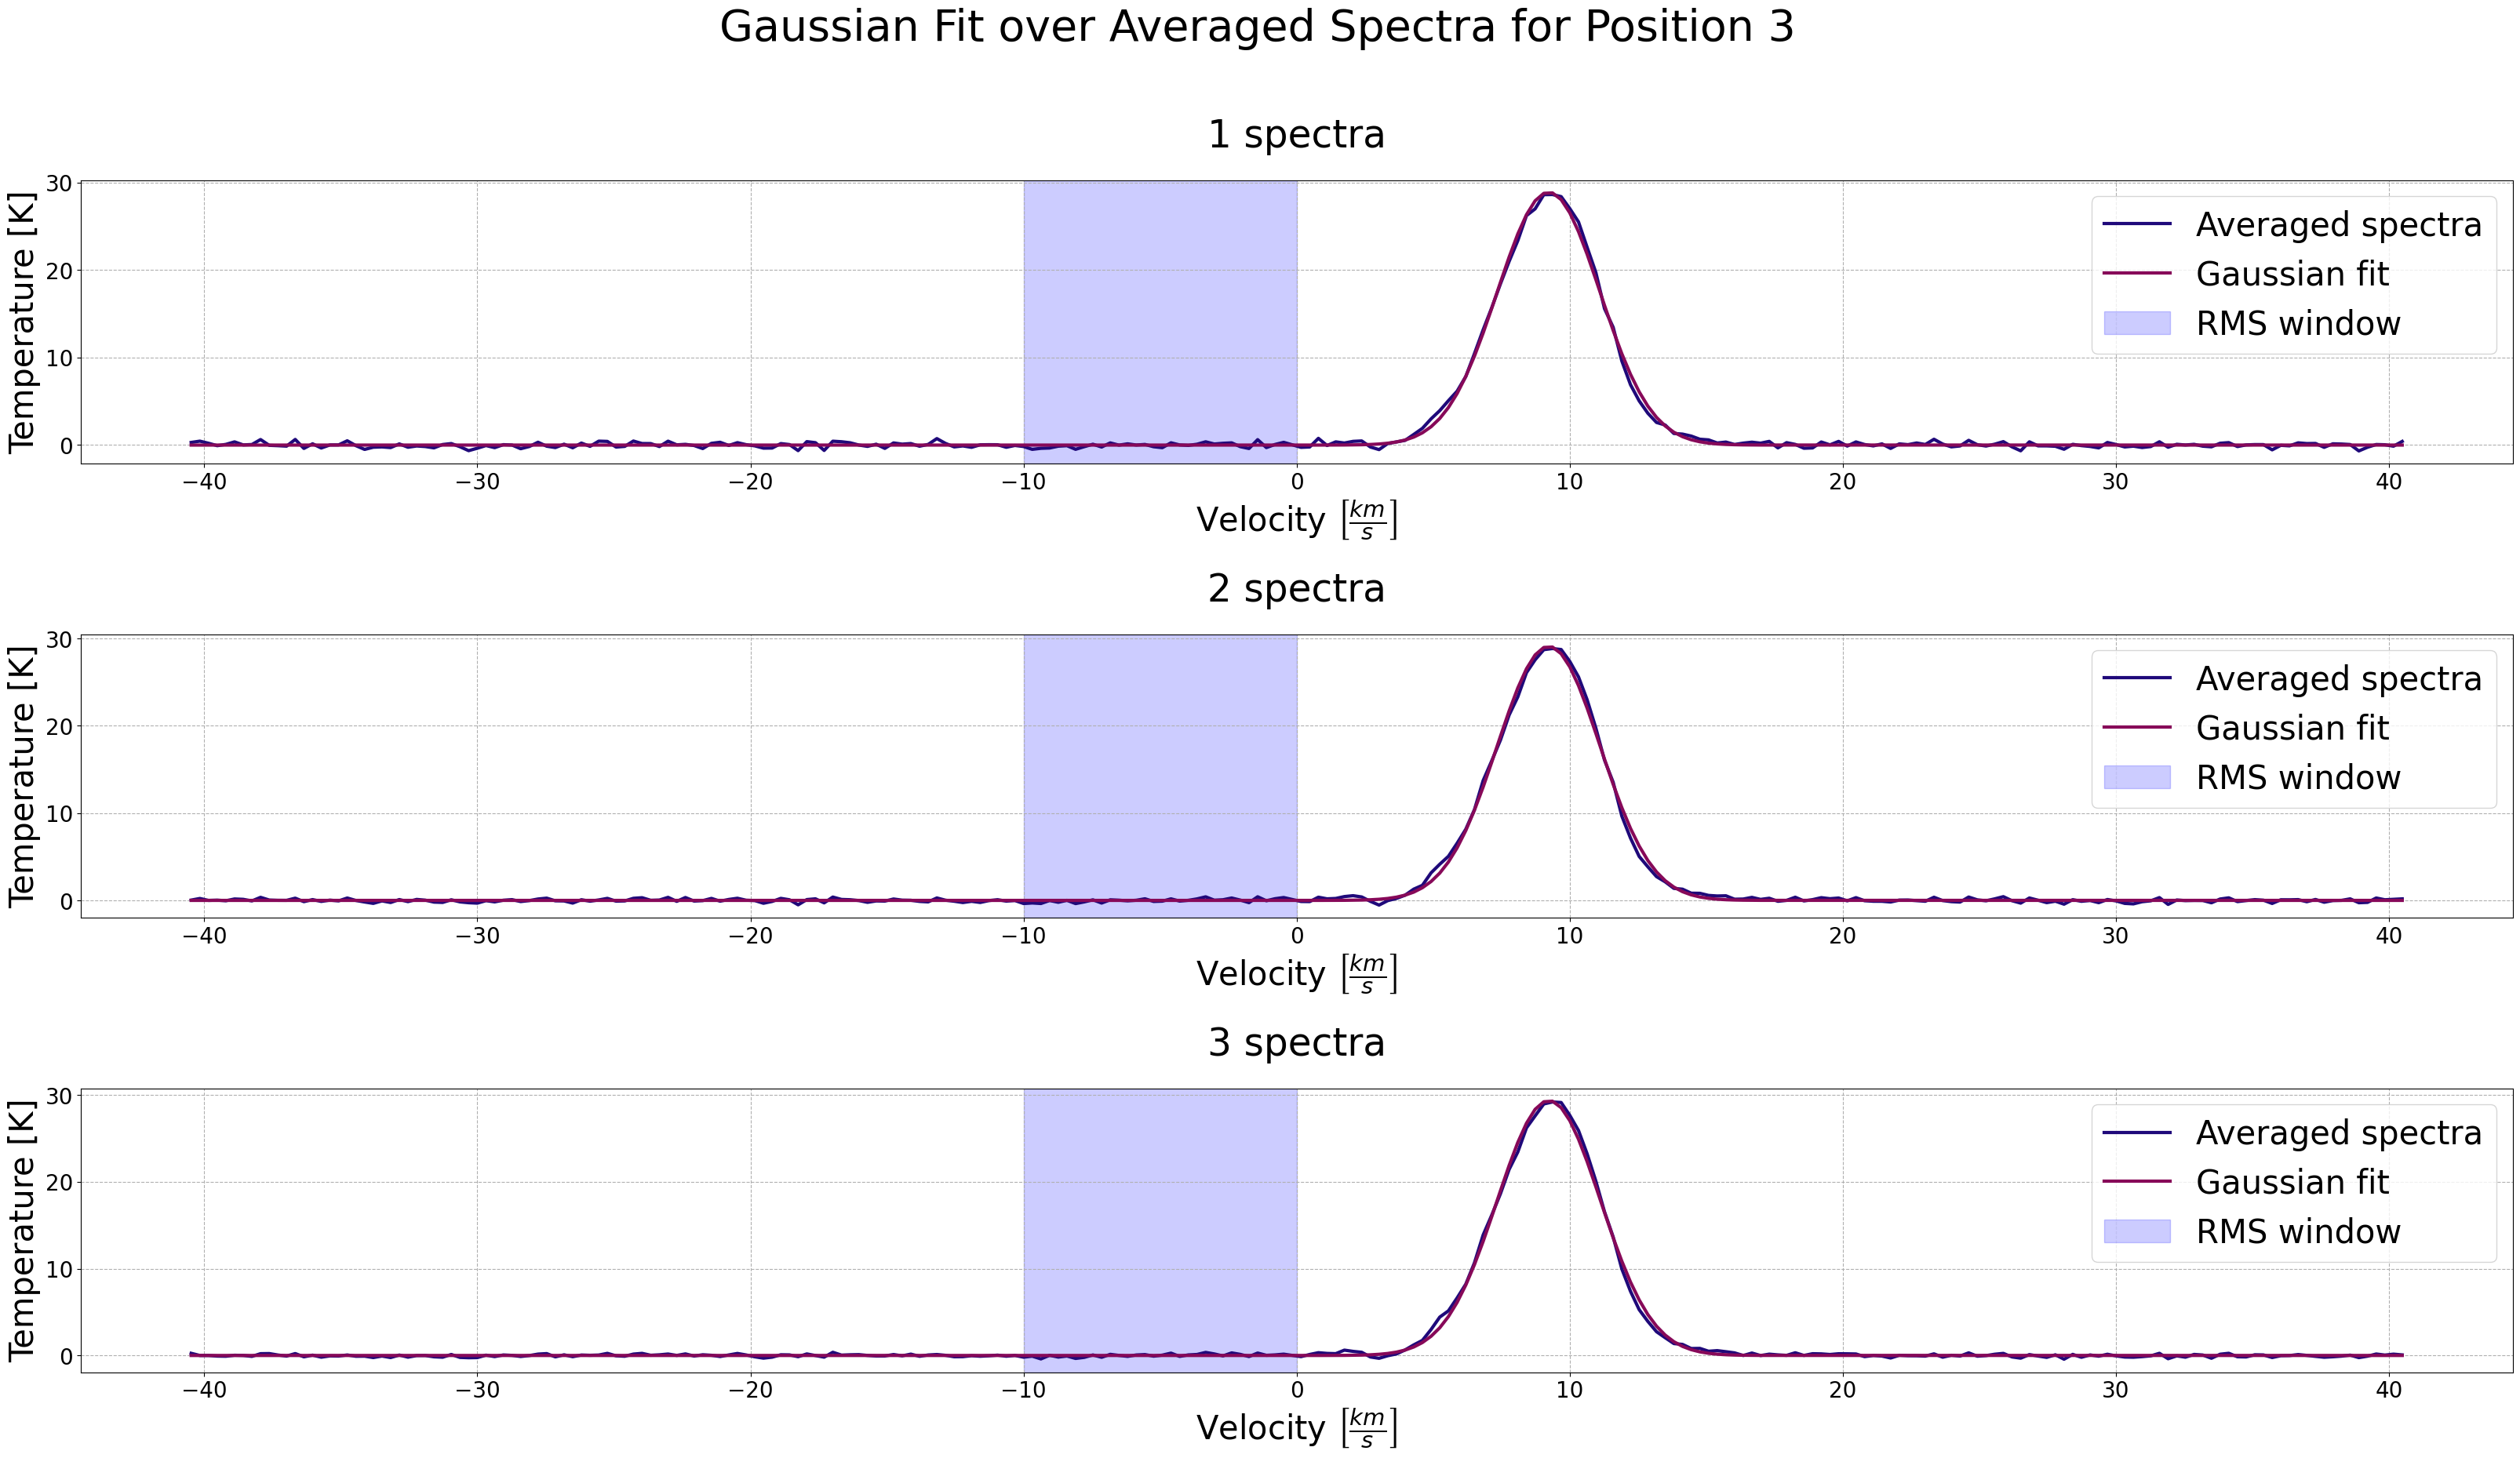

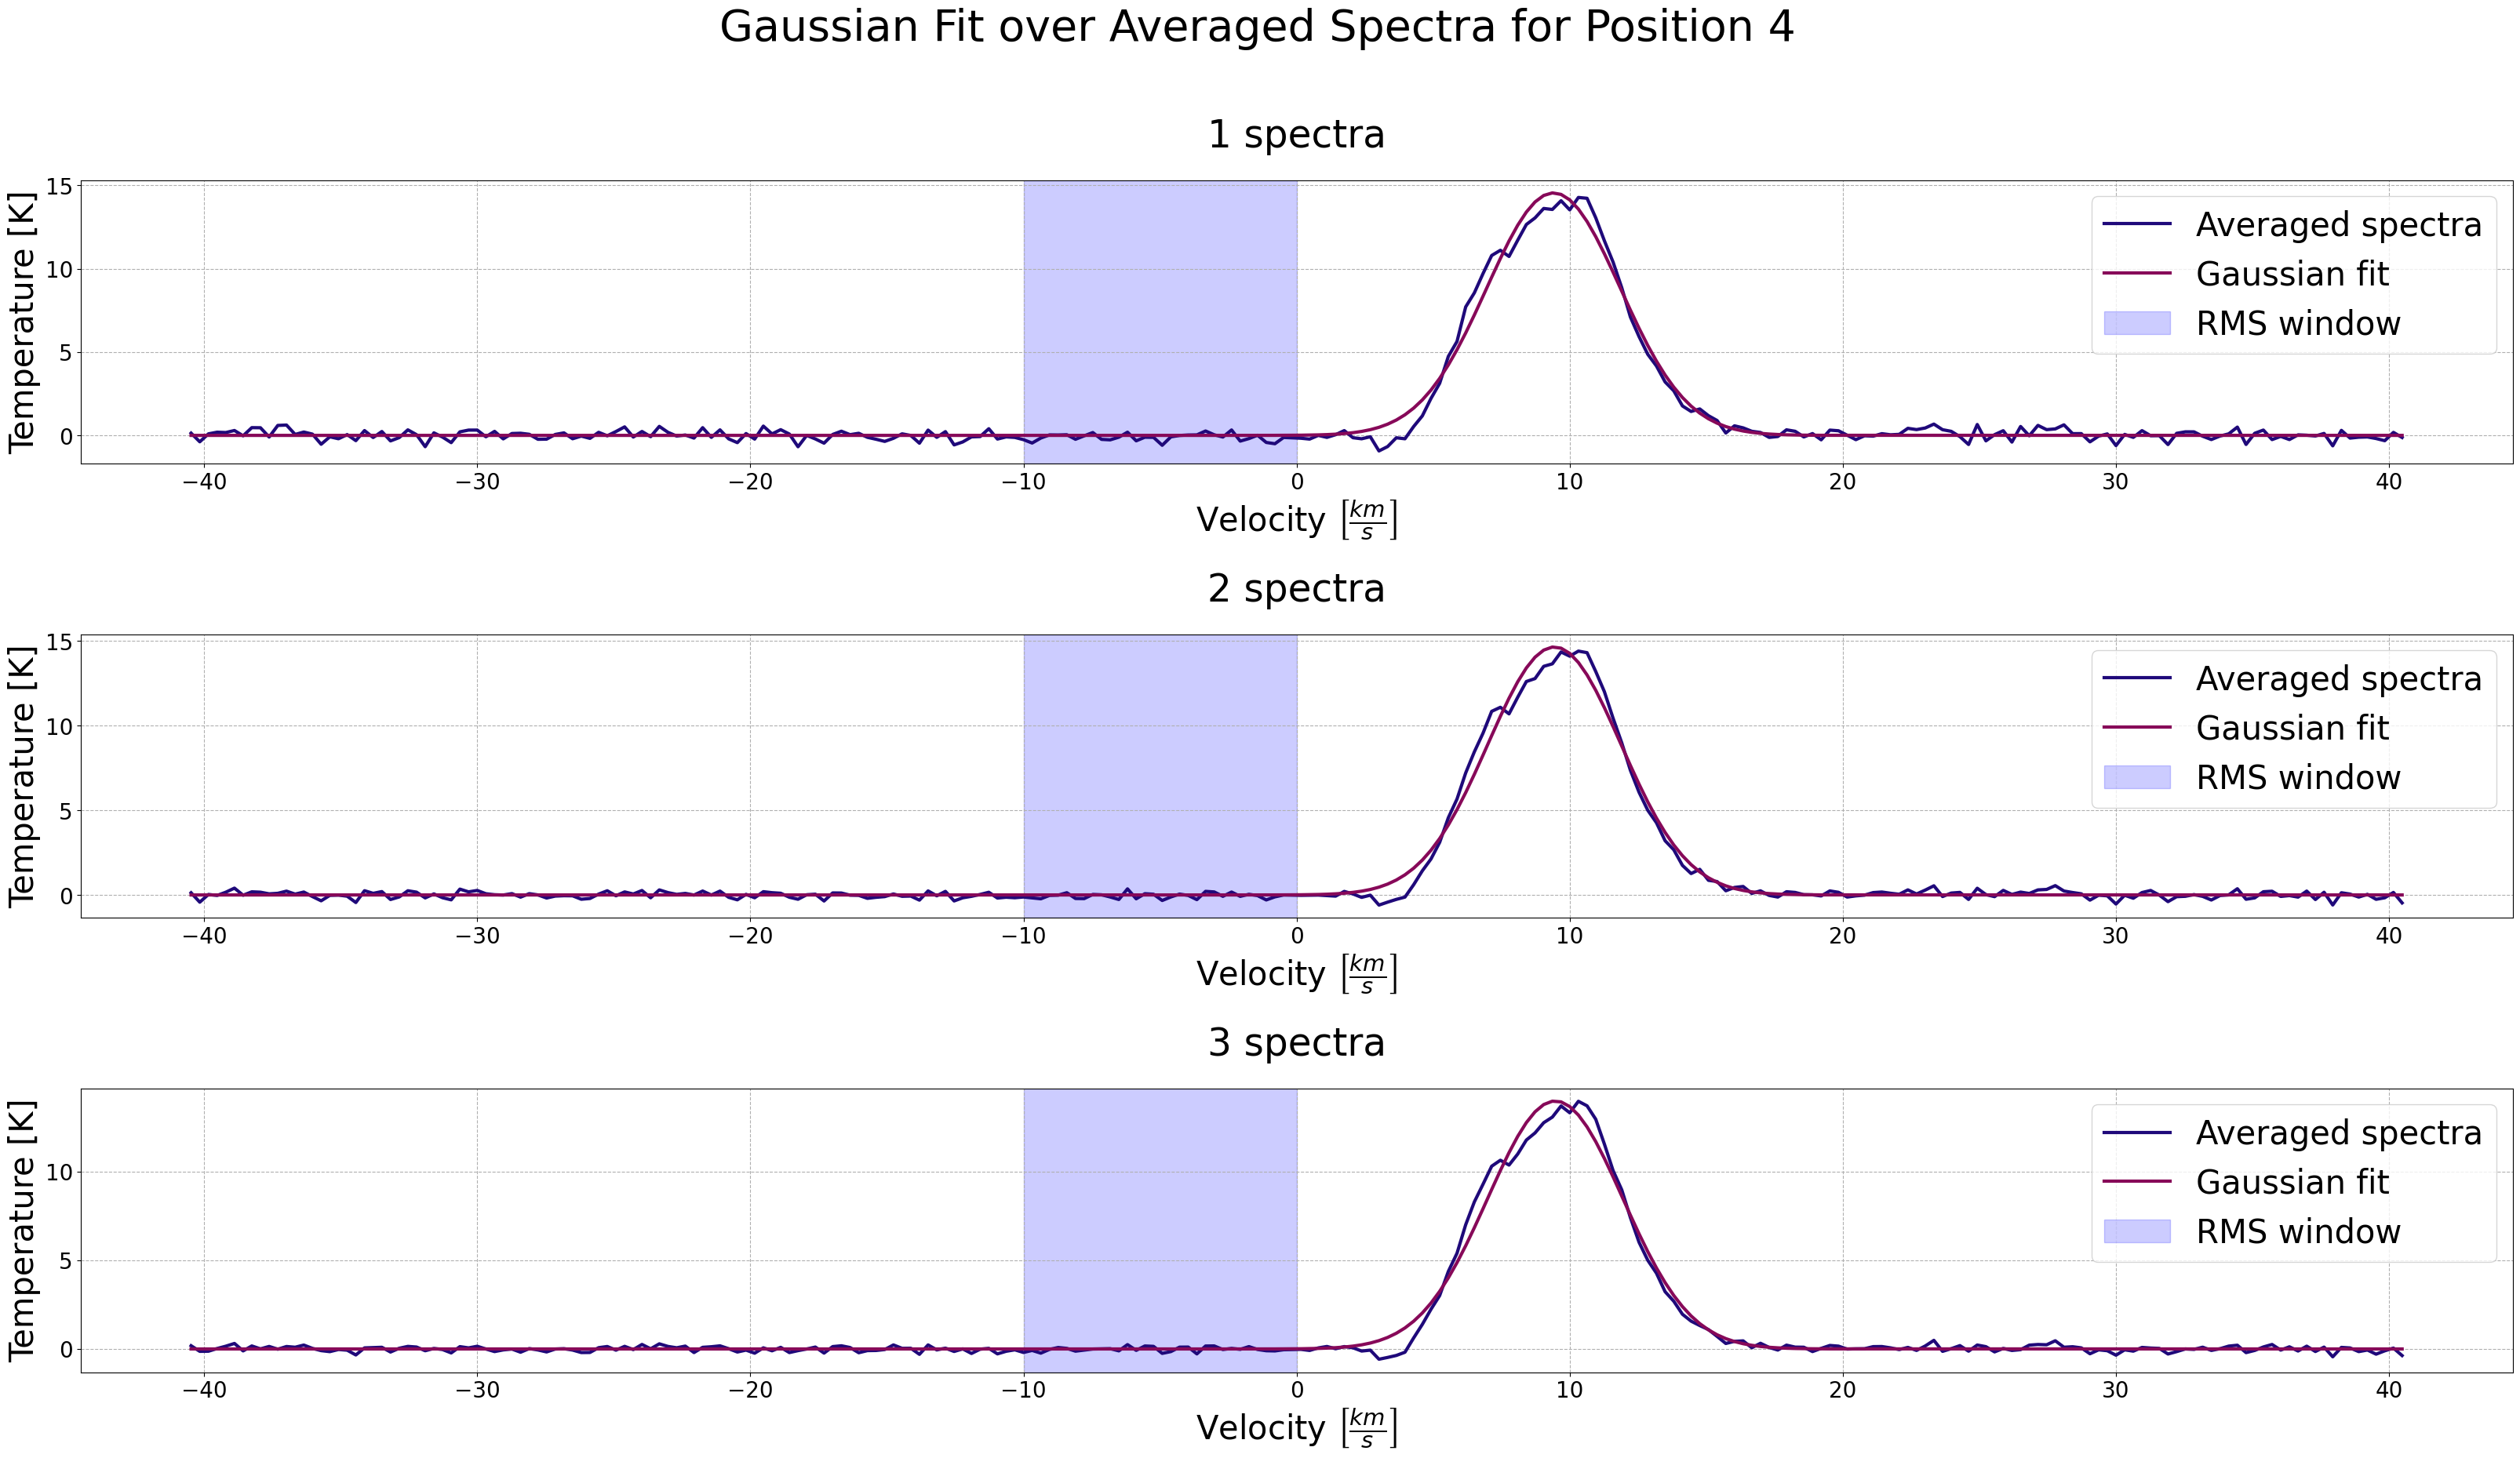

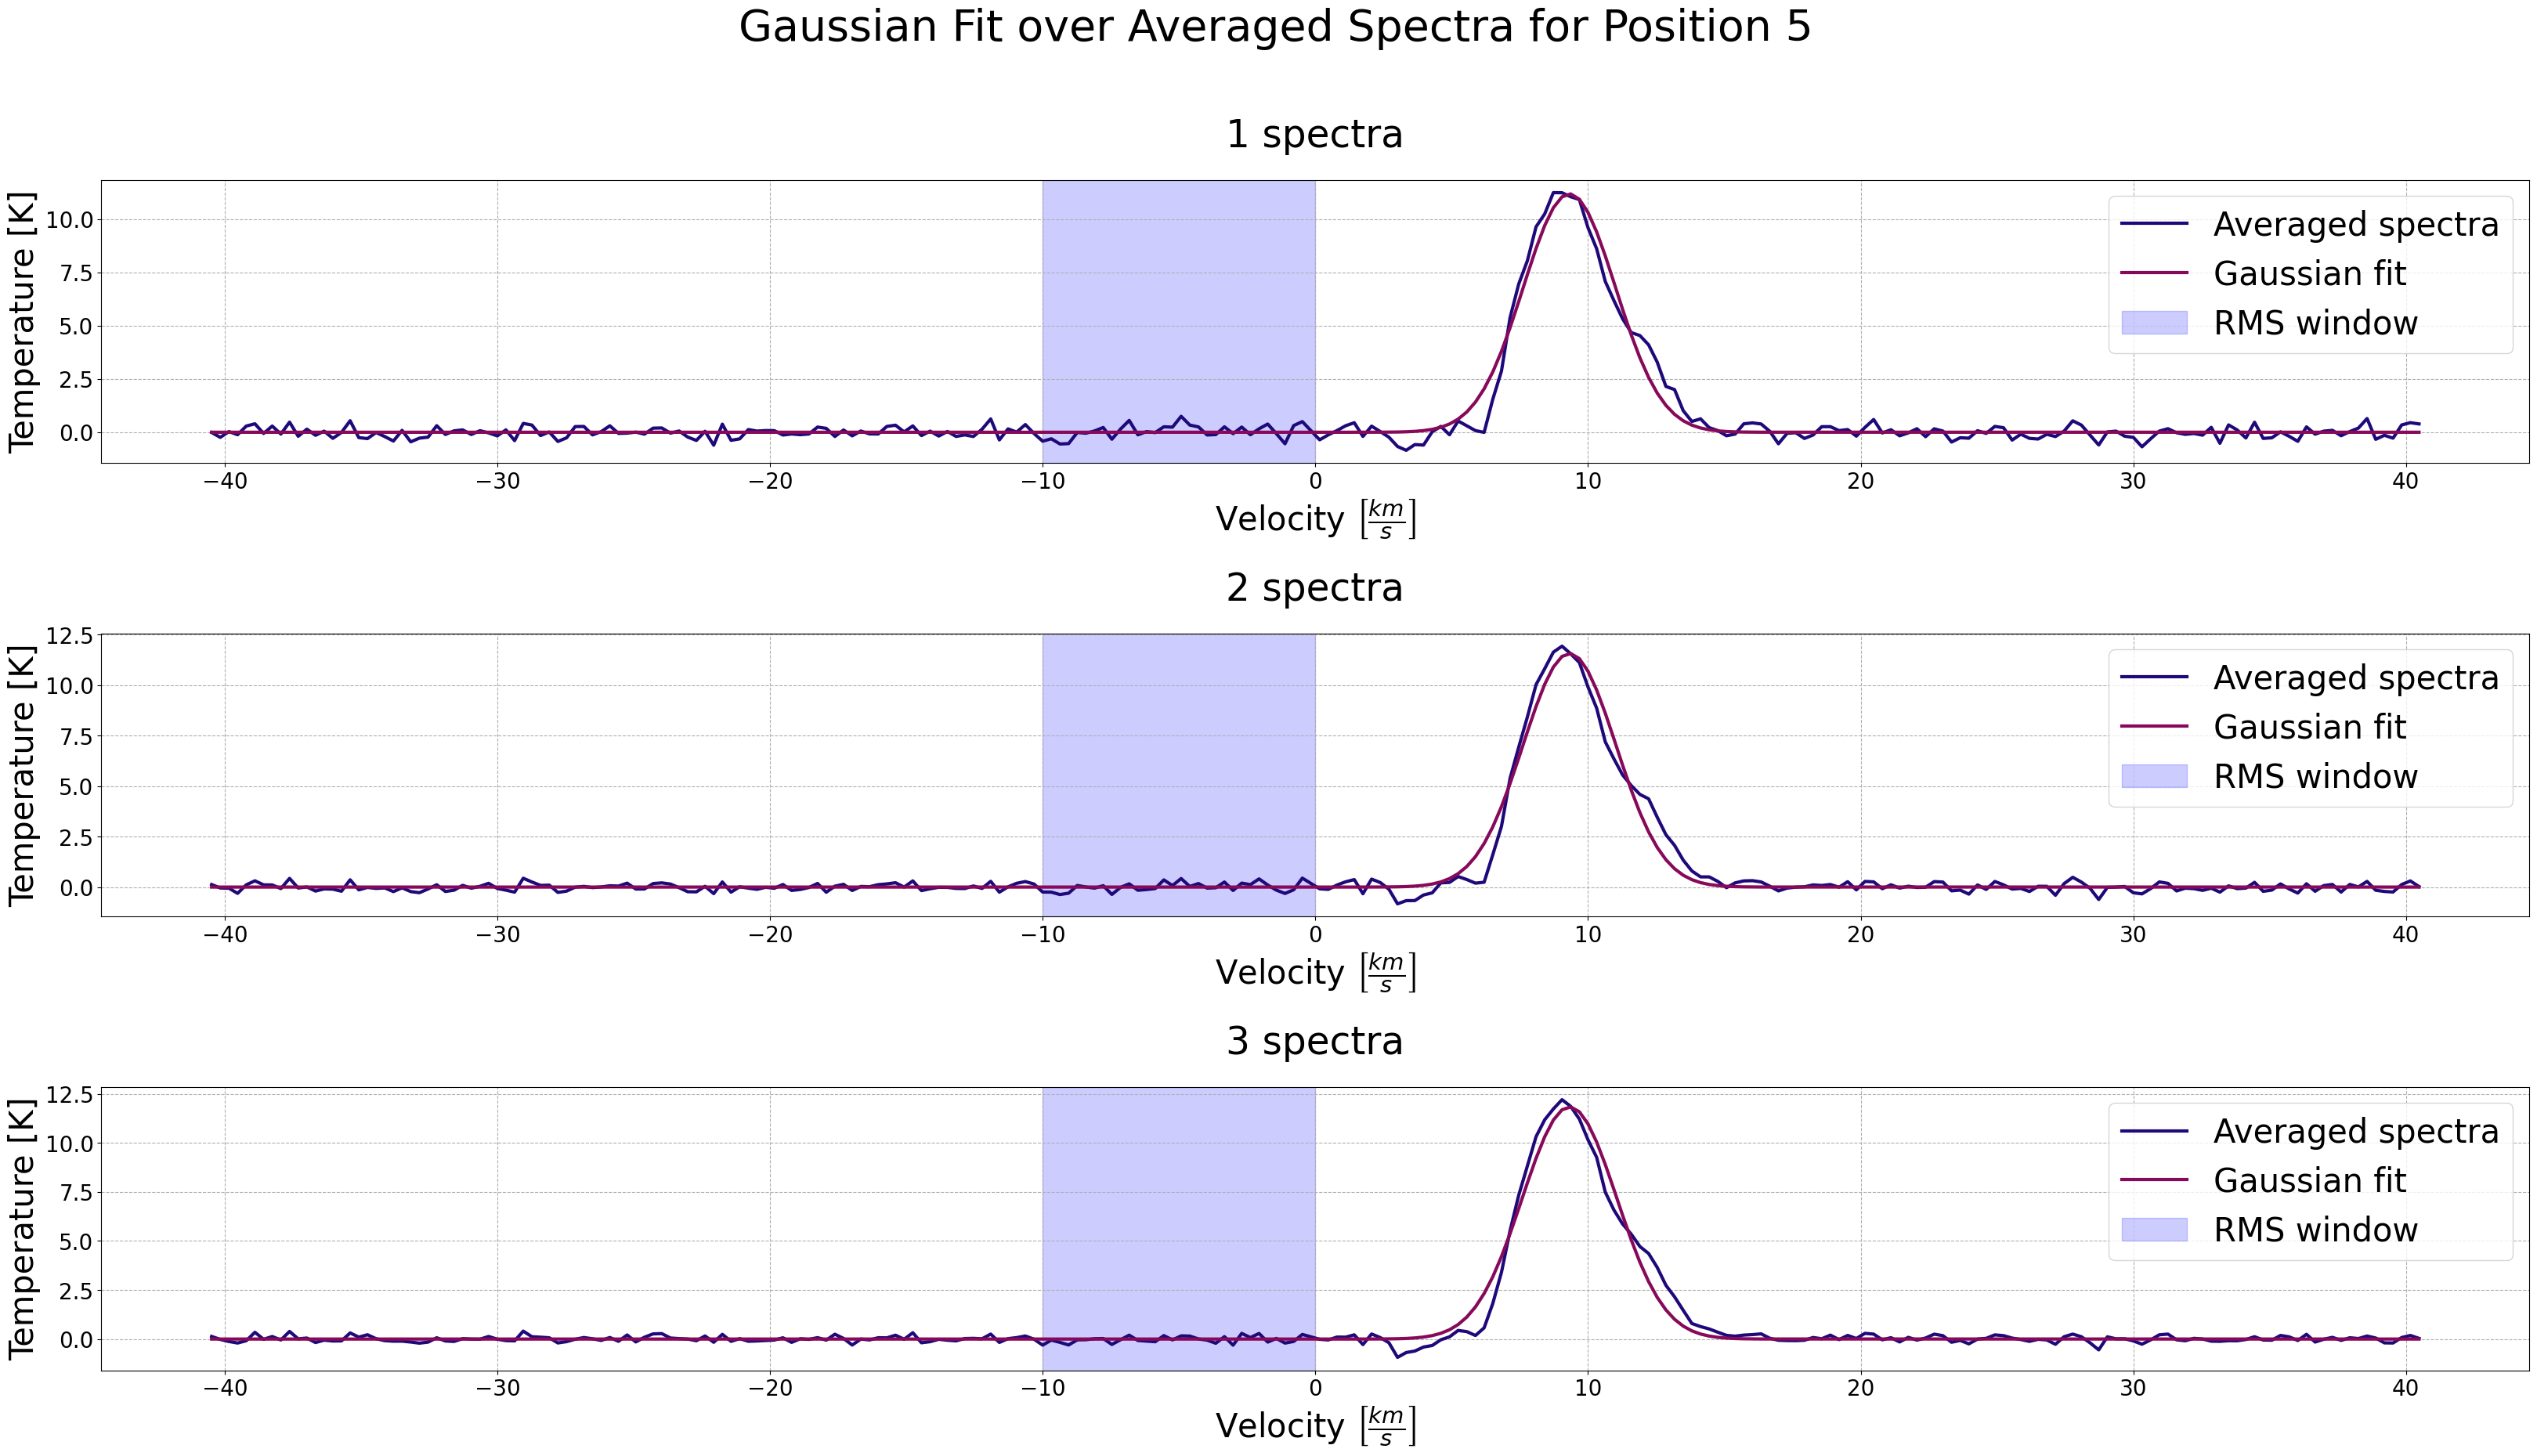

In [43]:
def fn_gauss(x, T0, mean, std):
    return T0*np.exp(-((x - mean)**2)/(2*(std**2)))

rms_pos_i = []
fg = [20, 10, 1]
mask = (v >= -10) & (v <= 0)

for k, i in enumerate(spec_vT_means):
    fig, axes = plt.subplots(3, 1, figsize = (40, 20))

    axes = axes.flatten()

    rms_pos = []
    for j, (v, T) in enumerate(i):
        coefs, cov = curve_fit(fn_gauss, v, T, p0 = fg)

        t0, M, S = coefs

        gauss_fit = fn_gauss(v, t0, M, S)

        resta = T - gauss_fit

        masked_resta  = resta[mask]

        rms_pos.append(np.std(masked_resta))

        axes[j].plot(v, T, 
                     color = "#1f097a", 
                     linestyle = "-", 
                     linewidth = 3, 
                     label = 'Averaged spectra'
                     )
        axes[j].plot(v, 
                     gauss_fit, 
                     color = "#870959", 
                     linestyle = "-", 
                     linewidth = 3, 
                     label = 'Gaussian fit'
                     )
        
        axes[j].set_xlabel(r"Velocity $\left[ \frac{km}{s}\right]$", 
                           fontsize = 30)
        axes[j].set_ylabel(r"Temperature [K]", 
                           fontsize = 30)

        axes[j].set_title(str(j + 1) + ' spectra', fontsize = 35, pad = 30)

        
        axes[j].axvspan(-10, 0, color='blue', alpha=0.2, label='RMS window')

        axes[j].grid(True, linestyle = "--", alpha = 1)
        axes[j].tick_params(labelsize = 20)
        axes[j].legend(fontsize = 30)
   
        fig.suptitle('Gaussian Fit over Averaged Spectra for Position ' 
                     + str(k + 1), fontsize = 40, ha = 'center')
        
        fig.subplots_adjust(top = 0.87, hspace = 0.6)
        
    plt.show()    
    rms_pos_i.append(rms_pos)


In [45]:
rms_pos_exp = []
rms_df = []
num = range(len(rms_pos_i))

for k, i in enumerate(rms_pos_i):
    rms0 = i[0]
    rmsexp = [rms0/np.sqrt(j + 1) for j in range(len(i))]
    rms_pos_exp.append(rmsexp)
    rms_df.append(rms_pos_i[k])
    rms_df.append(rms_pos_exp[k])

col = [f'Experimental RMS #{j}' if i % 2 == 0 else f'Expected RMS #{j}' for j in range(1, 6) for i in range(2)]
ind = [f'{j} Averaged Spectra' for j in range(1, 4)]

rms_df = dict(zip(col, rms_df))

rms_df = pd.DataFrame(rms_df, index = ind)
print(rms_df.to_latex(float_format='%.6f'))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & Experimental RMS #1 & Expected RMS #1 & Experimental RMS #2 & Expected RMS #2 & Experimental RMS #3 & Expected RMS #3 & Experimental RMS #4 & Expected RMS #4 & Experimental RMS #5 & Expected RMS #5 \\
\midrule
1 Averaged Spectra & 0.312338 & 0.312338 & 0.243979 & 0.243979 & 0.259382 & 0.259382 & 0.212876 & 0.212876 & 0.314152 & 0.314152 \\
2 Averaged Spectra & 0.184161 & 0.220856 & 0.179598 & 0.172519 & 0.211445 & 0.183411 & 0.159743 & 0.150526 & 0.223640 & 0.222139 \\
3 Averaged Spectra & 0.154940 & 0.180328 & 0.181813 & 0.140861 & 0.175778 & 0.149754 & 0.129383 & 0.122904 & 0.169460 & 0.181376 \\
\bottomrule
\end{tabular}



In [37]:
mean_pos_data = []

for i in spec_data:
    transposed = list(zip(*i))
    pos_mean = []
    for j in transposed:
        if type(j[0]) == float:
            mean = np.mean(j)
        else:
            stack = np.stack(j)
            mean = np.mean(j, axis = 0)
        pos_mean.append(mean)
    mean_pos_data.append(pos_mean)

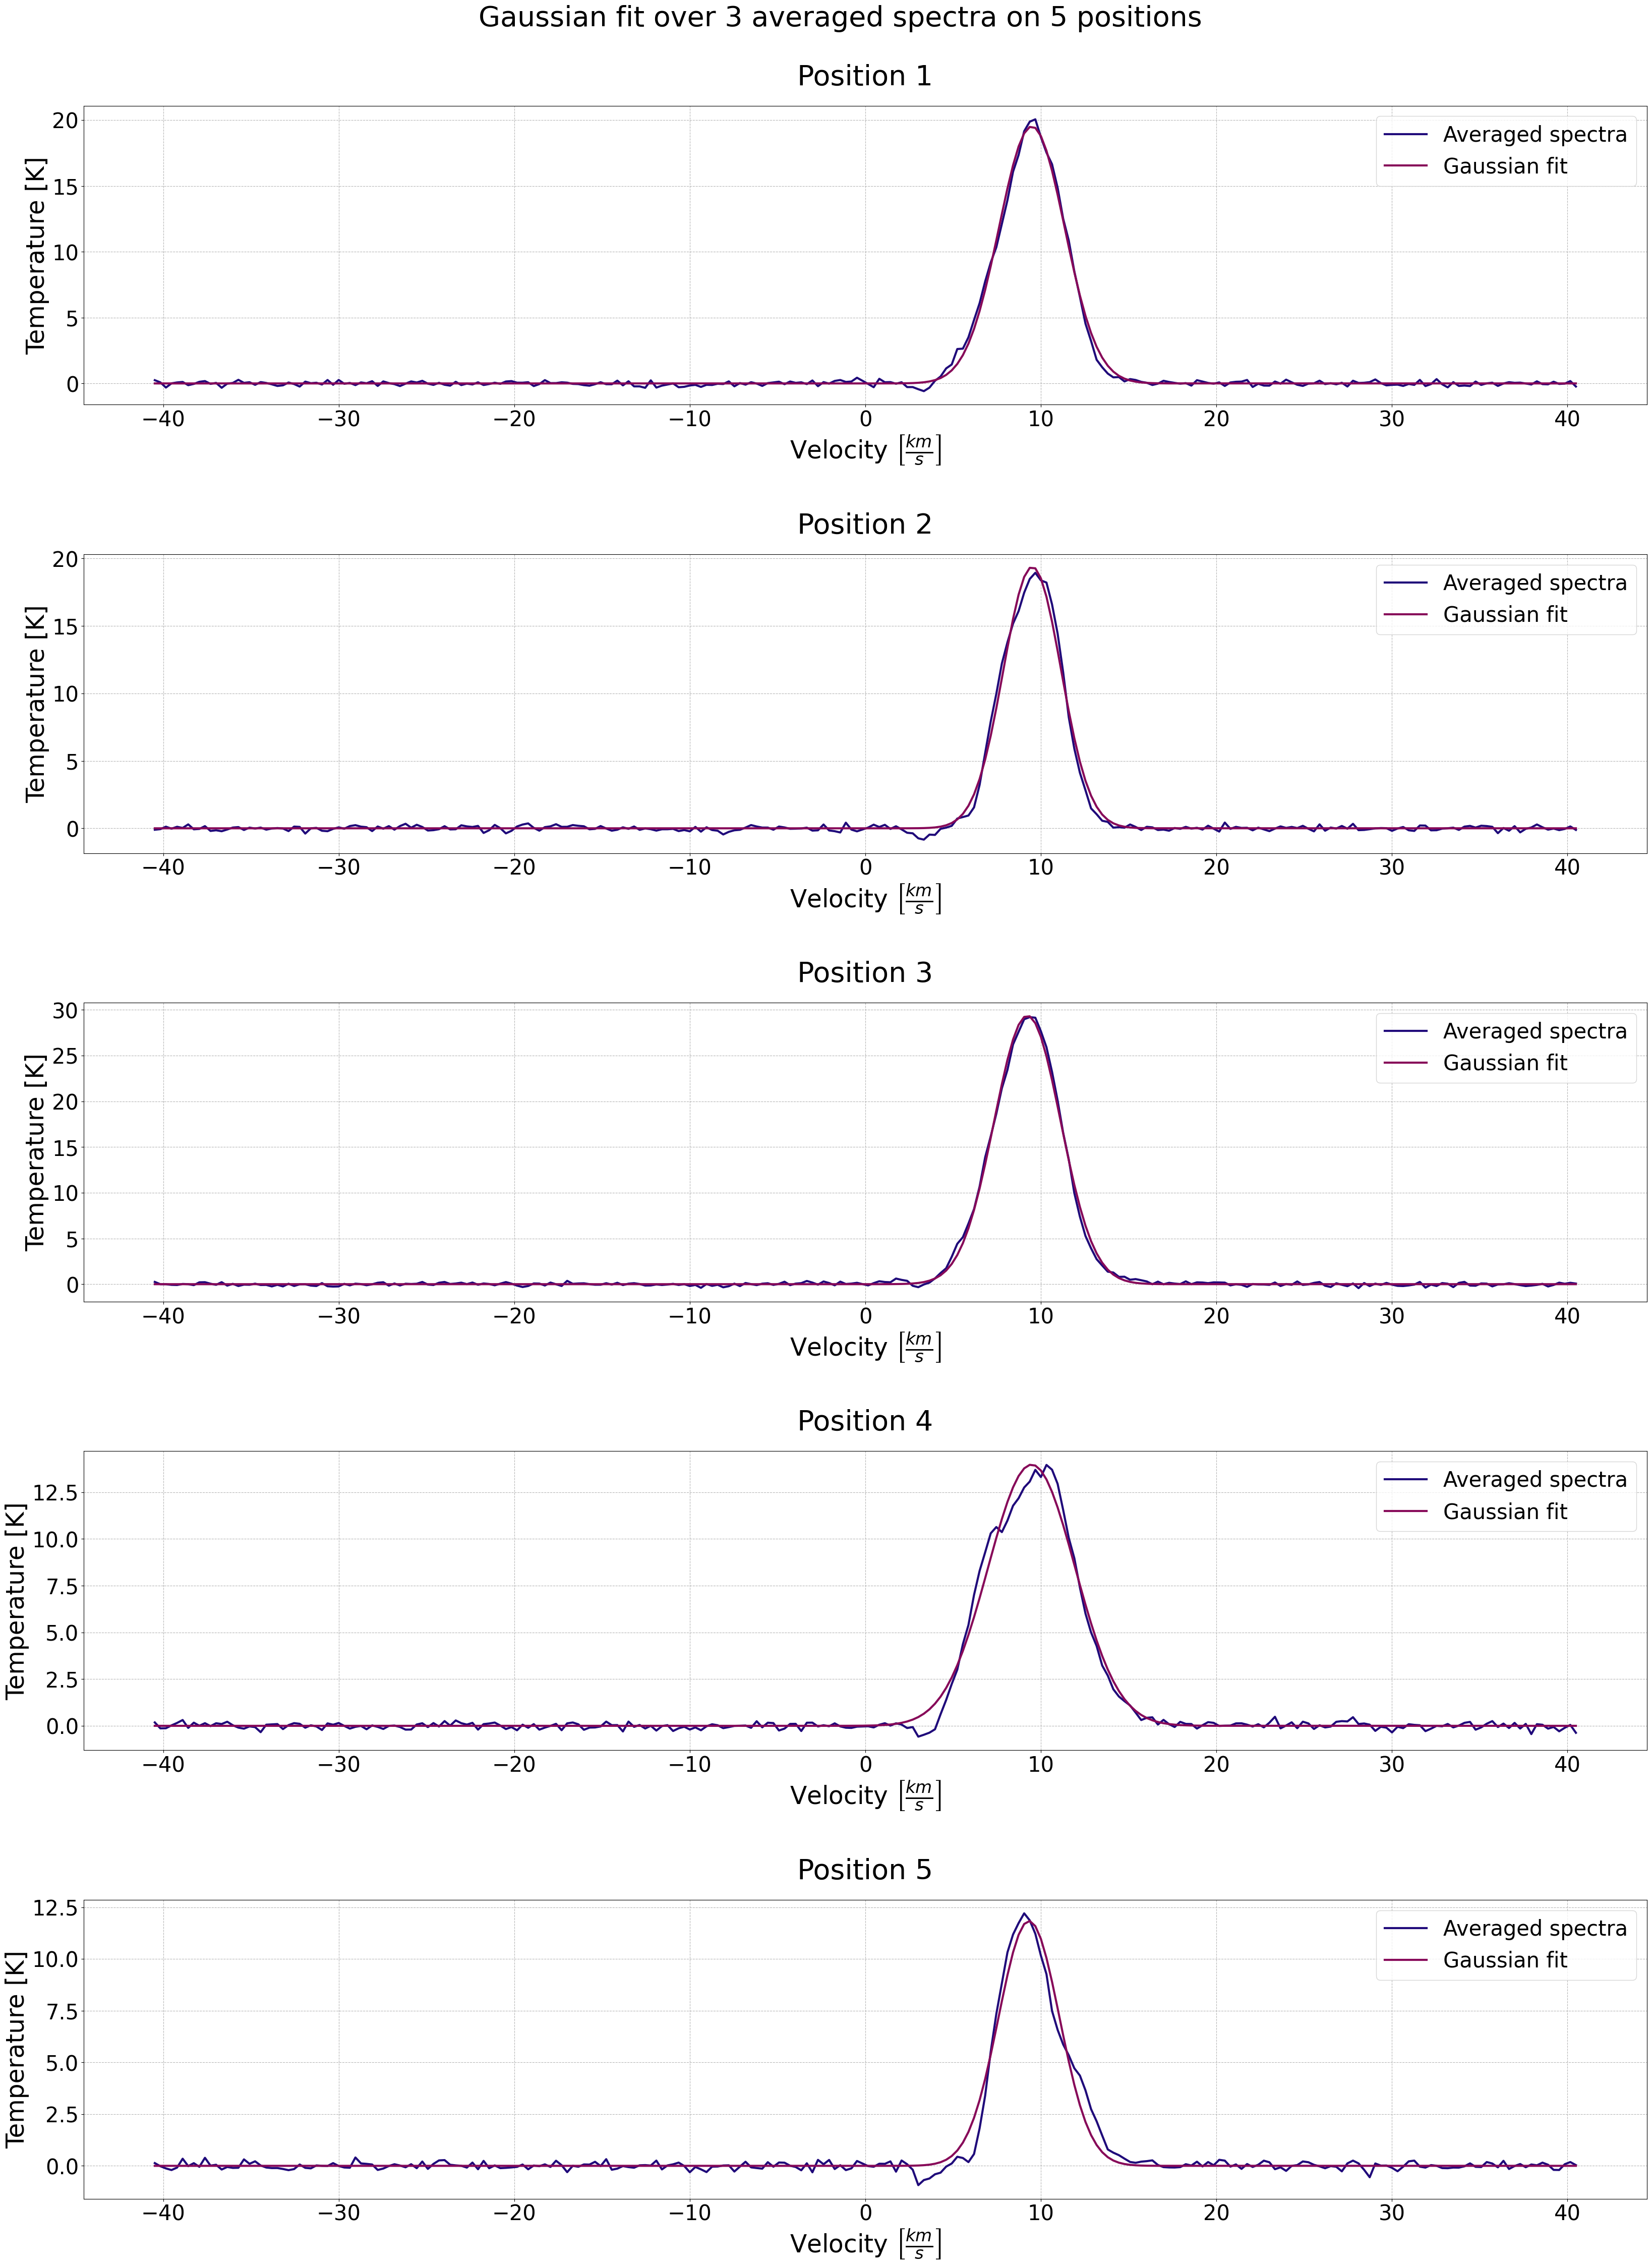

In [38]:
T_max = []

fig, axes = plt.subplots(5, 1, figsize = (40, 50))

axes = axes.flatten()

for k, i in enumerate(mean_pos_data):

    *coords, v, T = i

    fg = [20, 10, 1] 

    coefs, cov = curve_fit(fn_gauss, v, T, p0=fg) 

    t0, M, S = coefs[0], coefs[1], coefs[2]

    T_max.append(t0)

    gauss_fit = fn_gauss(v, t0, M, S)

    axes[k].plot(v, T, color = "#1f097a", linestyle = "-", linewidth = 3, label = 'Averaged spectra')
    axes[k].plot(v, gauss_fit, color = "#870959", linestyle = "-", linewidth = 3, label = 'Gaussian fit')
            
    axes[k].set_xlabel(r"Velocity $\left[ \frac{km}{s}\right]$", fontsize=35)
    axes[k].set_ylabel(r"Temperature [K]", fontsize=35)

    axes[k].set_title('Position ' + str(k + 1), fontsize = 40, pad = 30)

    axes[k].grid(True, linestyle = "--", alpha=0.9)
    axes[k].tick_params(labelsize = 30)
    axes[k].legend(fontsize = 30)
   
fig.suptitle('Gaussian fit over 3 averaged spectra on 5 positions', fontsize = 40)

fig.subplots_adjust(top = 0.94, hspace = 0.5)
plt.show() 

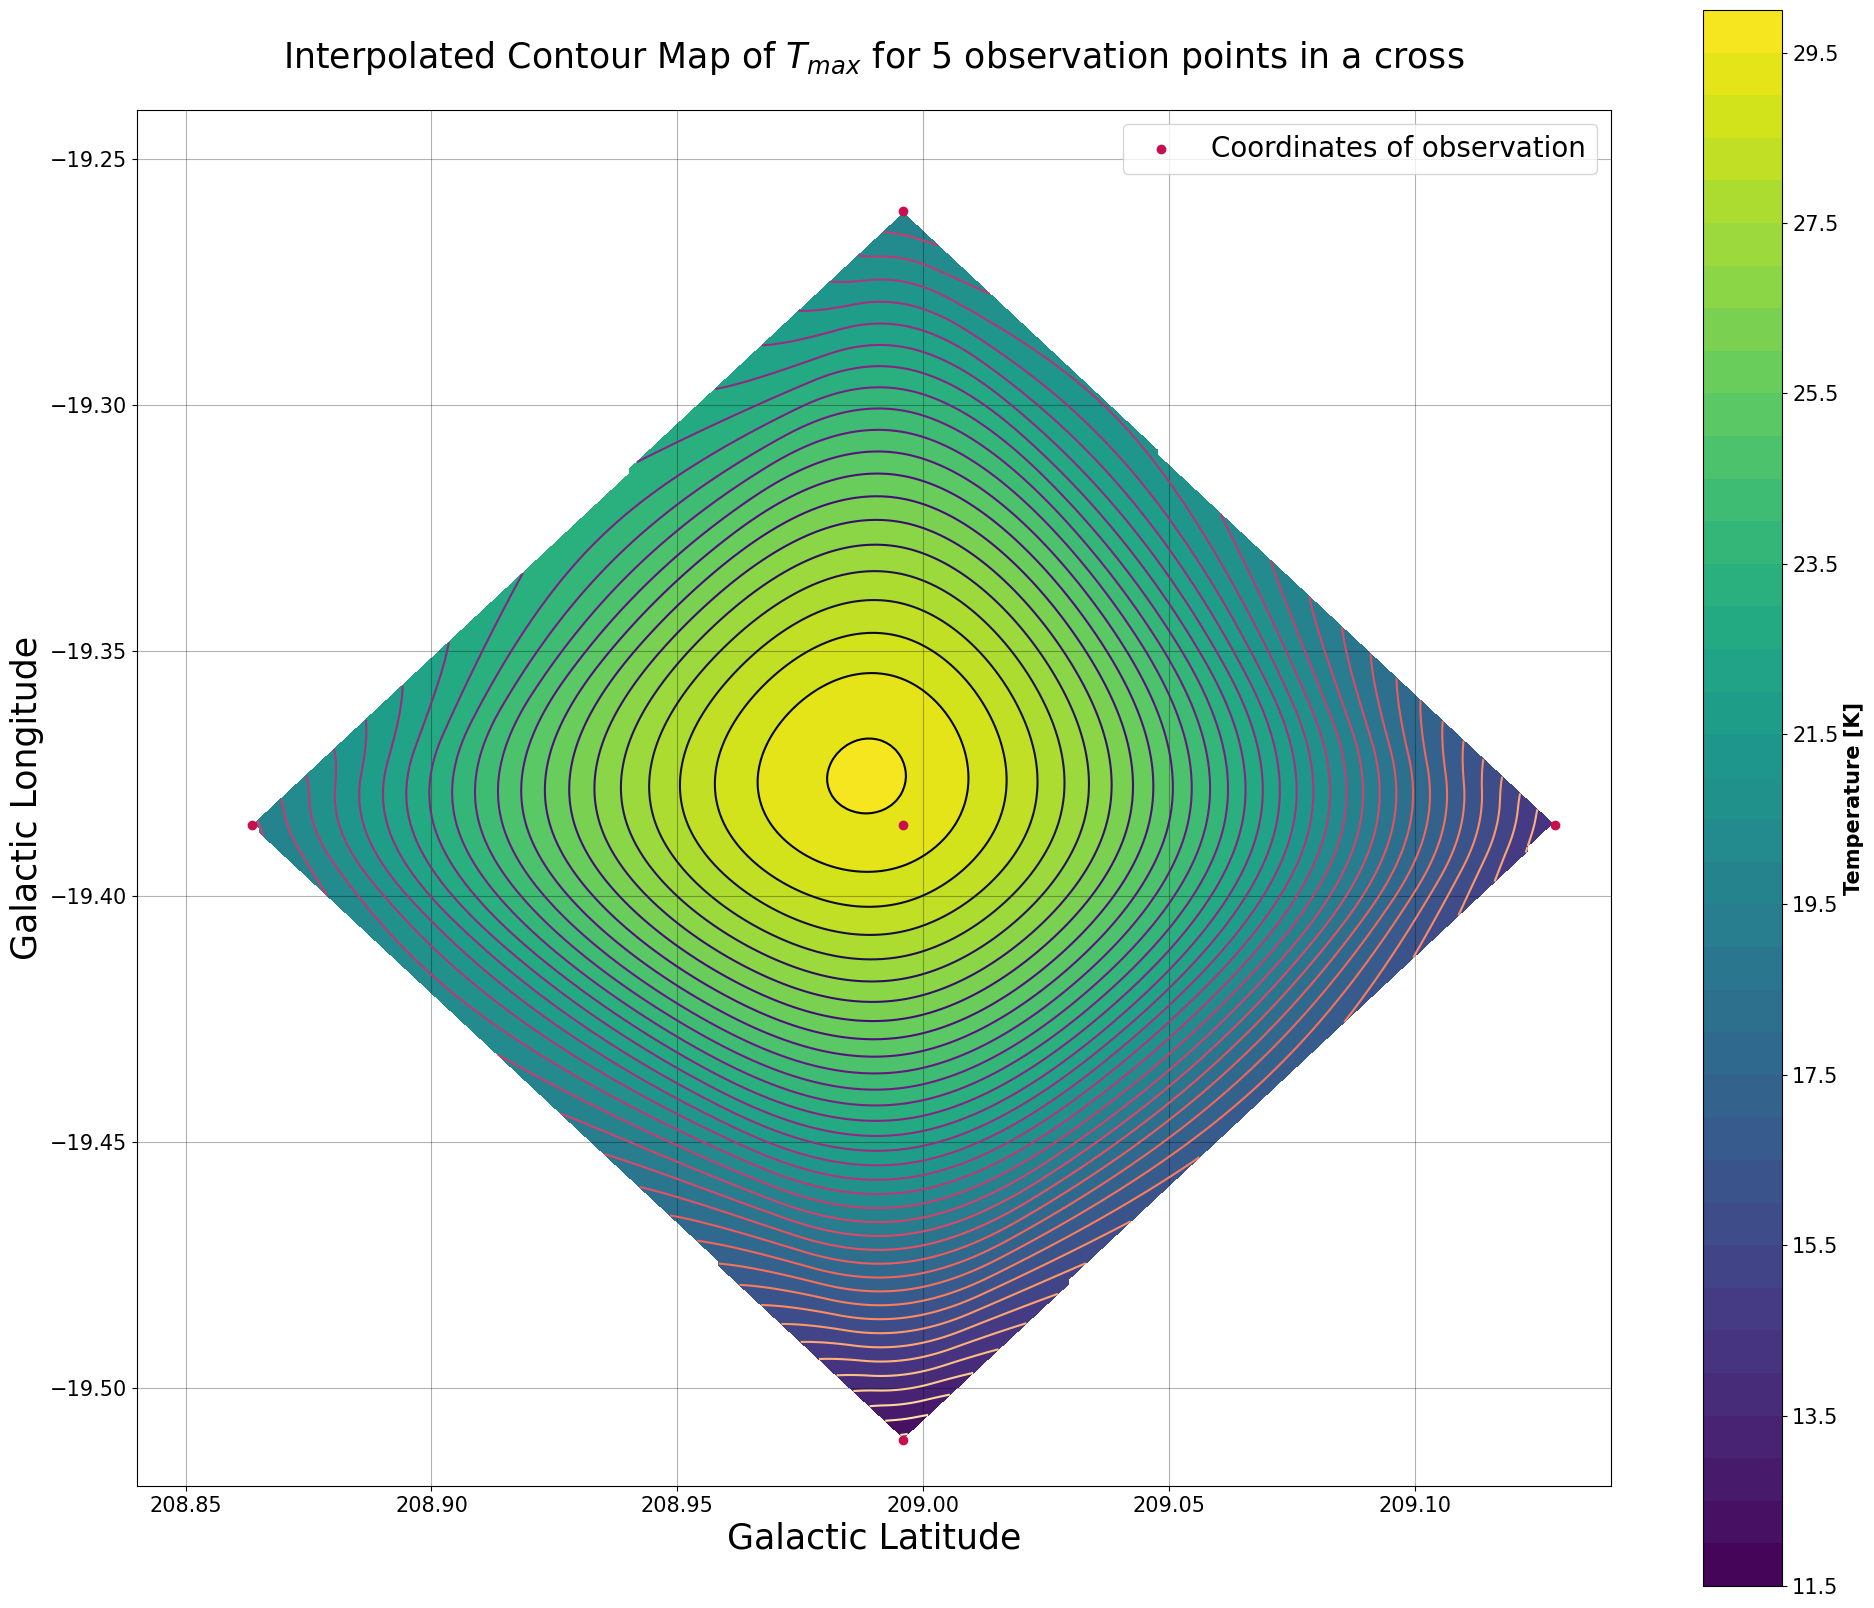

In [39]:
points = [(mean_pos_data[i][0], mean_pos_data[i][1]) for i in range(len(mean_pos_data))]

points = np.array(points)

T_max = np.array(T_max)

gridx, gridy = np.mgrid[208.84:209.14:300j, -19.52:-19.24:300j]

gridz = griddata(points, T_max, (gridx, gridy), method = 'cubic')

plt.figure(figsize = (20, 20), layout = 'tight')
plt.contourf(gridx, gridy, gridz, levels = 43, cmap = "viridis")
cb = plt.colorbar(shrink = 0.8)
cb.set_label(label='Temperature [K]', weight='bold', size = 15)
cb.ax.tick_params(labelsize = 15)
plt.contour(gridx, gridy, gridz, levels = 43, cmap = "magma_r")
plt.scatter(points[:, 0], points[:, 1], color = '#c90e50', 
            label = 'Coordinates of observation', 
            zorder = 5)
plt.title('Interpolated Contour Map of $T_{max}$ for 5 observation points in a cross', 
          fontsize = 25,
          pad = 30)
plt.xlabel('Galactic Latitude', fontsize = 25)
plt.ylabel('Galactic Longitude', fontsize = 25)
plt.tick_params(labelsize = 15)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.grid(True, linestyle = '-', alpha = 0.3, color = 'k')
plt.legend(fontsize = 20)
plt.show()

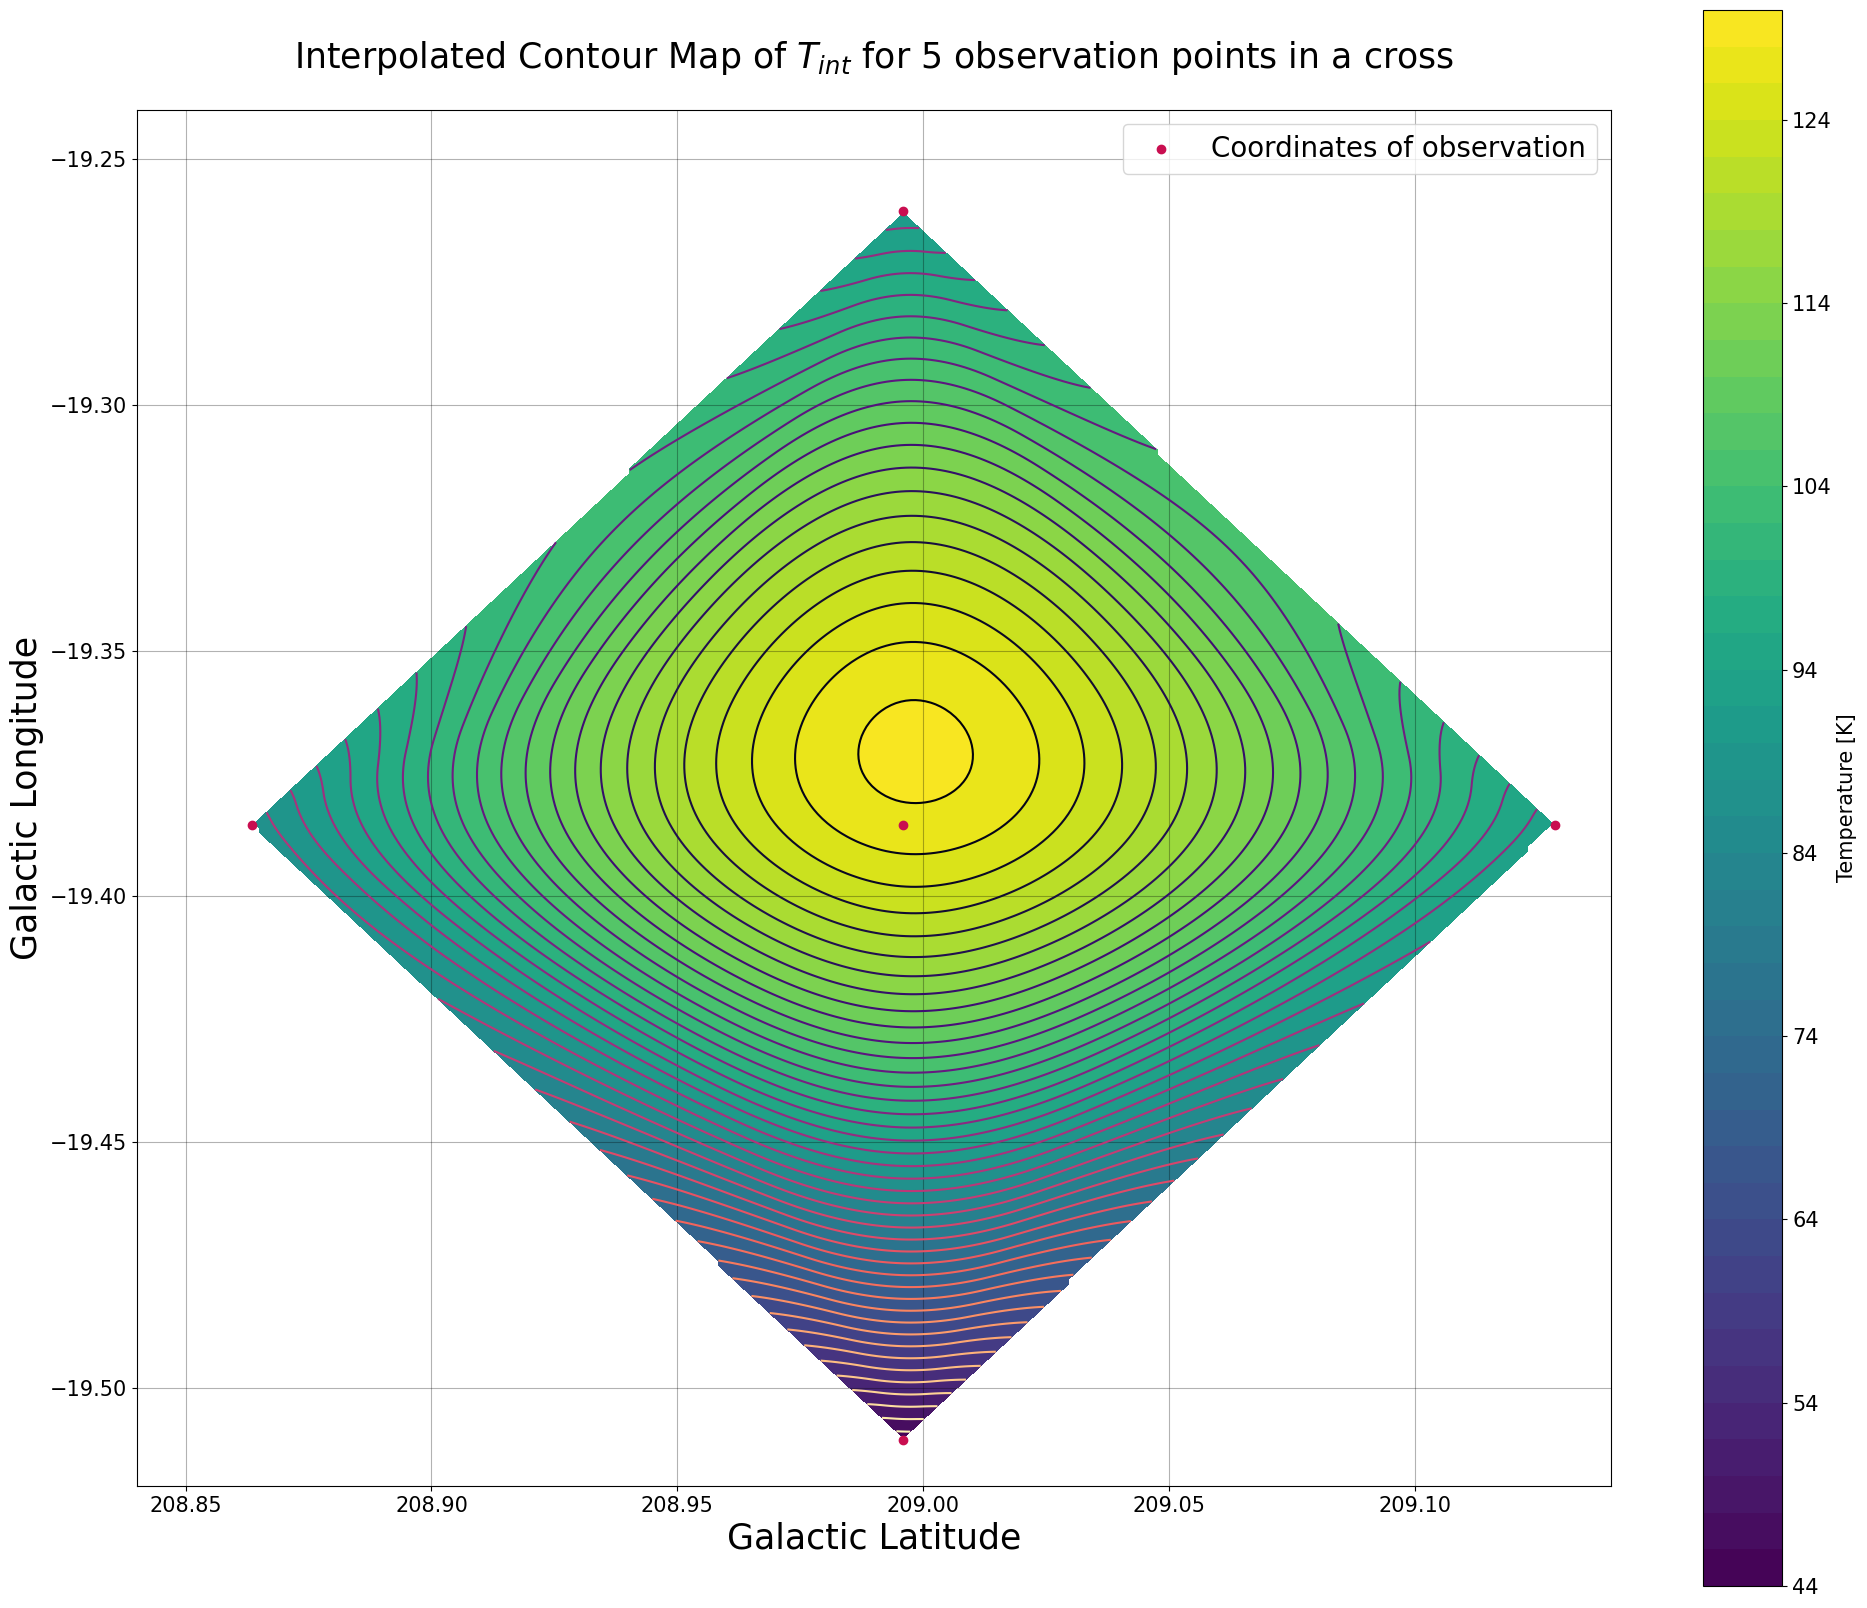

In [40]:
T_int = []
for i in mean_pos_data:
    T_int.append(np.trapezoid(i[2], i[3]))

T_int = np.array(T_int)

gridzint = griddata(points, T_int, (gridx, gridy), method = 'cubic')

plt.figure(figsize = (20, 20), layout = 'tight')
plt.contourf(gridx, gridy, gridzint, levels = 43, cmap = "viridis")
cb = plt.colorbar(shrink = 0.8)
cb.set_label(label='Temperature [K]', size = 15)
cb.ax.tick_params(labelsize = 15)
plt.contour(gridx, gridy, gridzint, levels = 43, cmap = "magma_r")
plt.scatter(points[:, 0], points[:, 1], color = '#c90e50', 
            label = 'Coordinates of observation', 
            zorder = 5)
plt.title('Interpolated Contour Map of $T_{int}$ for 5 observation points in a cross', 
          fontsize = 25,
          pad = 30)

plt.xlabel('Galactic Latitude', fontsize = 25)
plt.ylabel('Galactic Longitude', fontsize = 25)
plt.tick_params(labelsize = 15)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.grid(True, linestyle = '-', alpha = 0.3, color = 'k')
plt.legend(fontsize = 20)

plt.show()